In [5]:
import pickle
from pathlib import Path
from typing import NamedTuple
import os

import arviz as az
import haiku as hk
import jax
import jax.numpy as jnp
from jax.tree_util import tree_map
from jax.scipy.stats import multinomial
from mubelnet.utils import perplexity
from scipy.stats import entropy

from dataset import load_digits

# This environment variable needs to be set to a writable directory.
os.environ['ARTEFACT_DIR'] = '/home/hylke/digits_more_topics/digits_more_topics'


X_train, X_test = load_digits()


class TrainState(NamedTuple):
    params: hk.Params
    state: hk.State
    key: jax.Array  # type: ignore
    step: int

MODEL = 'multinomial_belief'
_bottom_layer_name = (
    f"{MODEL}/~/multinomial_layer"
    if MODEL == "multinomial_belief"
    else f"{MODEL}/~/poisson_layer"
)

In [6]:
state_dir = Path('/home/hylke/digits_more_topics/digits_more_topics/multinomial_belief/10-20-30/checkpoints/')
# state_dir = Path('/home/hylke/digits_more_topics/digits_more_topics/multinomial_belief/20-30/checkpoints/')
# state_dir = Path('/home/hylke/digits_more_topics/digits_more_topics/multinomial_belief/30/checkpoints/')
pickles = sorted(state_dir.glob('checkpoint_*.pkl'))
# Load the states from the pickles and concatenate along the second axis.
trace = []
n_thin_every = 10
for i, p_file in enumerate(pickles):
    if i % n_thin_every != 0:
        continue
    with open(p_file, 'rb') as fi:
        try:
            train_state = pickle.load(fi)
        except:
            print("Unable to load pickle file: ", p_file)
            continue
        trace.append(train_state.state)

In [7]:
extra_thin = 1
states = tree_map(lambda *xs: jnp.stack(xs, axis=1)[:, ::extra_thin], *trace)
del trace

In [8]:
def probability(state):
    bottom_state = state[_bottom_layer_name]
    phi = bottom_state['phi']
    theta = bottom_state["copy[theta(1)]"]
    probs = theta @ phi
    probs /= probs.sum(axis=-1, keepdims=True)
    return probs

def evaluate(params, states, X):
    """Compute perplexity over chains and samples by default (axis=[0, 1])."""
    probs = probability(states).mean([0, 1])
    return perplexity(X, probs)

In [9]:
probs = probability(states)
n_trials=X_test.sum(axis=-1)

In [10]:
log_likelihood = jax.vmap(jax.vmap(jax.vmap(multinomial.logpmf), in_axes=[None, None, 0]), in_axes=[None, None, 0])
lls = jnp.mean(log_likelihood(X_test.astype(int), n_trials.astype(int), probs), axis=2)

Text(0, 0.5, 'Log likelihood')

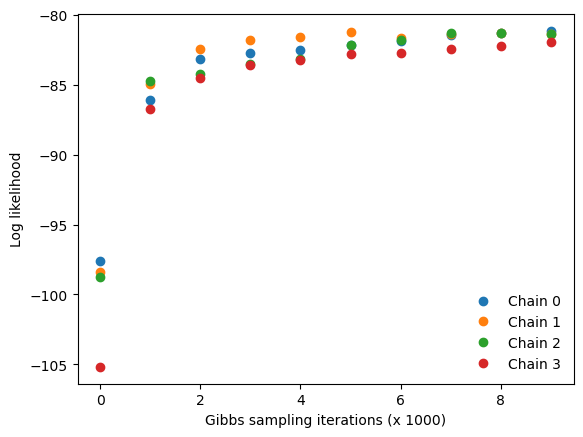

In [14]:
from matplotlib import pyplot as plt
plt.plot(lls[0,:10], 'o', label='Chain 0')
plt.plot(lls[1,:10], 'o', label='Chain 1')
plt.plot(lls[2,:10], 'o', label='Chain 2')
plt.plot(lls[3,:10], 'o', label='Chain 3')

plt.legend(frameon=False)
plt.xlabel('Gibbs sampling iterations (x 1000)')
plt.ylabel('Log likelihood')

In [16]:
# Convert states to arviz inference data.
r_entropy = entropy(states[f"{MODEL}/~/cap_layer"]["r"], axis=-1)
# theta_1_entropy = entropy(states[f"{MODEL}/~/dirichlet_layer"]["theta"], axis=-1)
theta_2_entropy = entropy(states[f"{MODEL}/~/cap_layer"]["theta"], axis=-1)
# phi_2_entropy = jnp.sum(entropy(states["multinomial_dirichlet_believe/~/dirichlet_layer"]["phi"], axis=-1), axis=-1)
idata = az.convert_to_inference_data(
    {
        "c(3)": states[f"{MODEL}/~/cap_layer"]["c"],
        "c(2)": states[f"{MODEL}/~/dirichlet_layer"]["c"],
        "c(1)": states[f"{MODEL}/~/dirichlet_layer_1"]["c"],
        # "s[phi(2)]": phi_2_entropy,
        "s[r]": r_entropy,
        # "s[theta(1)]": theta_1_entropy,
        # "s[theta(2)]": theta_2_entropy,
    }
)

In [17]:
summary = az.summary(idata)

In [18]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c(3),0.988,0.349,0.713,1.252,0.088,0.064,6.0,37.0,2.03
s[r],3.104,0.249,2.722,3.321,0.067,0.054,6.0,27.0,1.89


In [40]:
sthetas = [f's[theta(2)][{i}]' for i in range(1797)]
summary.loc[sthetas]['r_hat'].describe()

count    1797.000000
mean        1.531925
std         0.046262
min         1.320000
25%         1.500000
50%         1.530000
75%         1.560000
max         1.690000
Name: r_hat, dtype: float64

array([[<AxesSubplot: title={'center': 'c(3)'}>,
        <AxesSubplot: title={'center': 'c(3)'}>],
       [<AxesSubplot: title={'center': 'c(2)'}>,
        <AxesSubplot: title={'center': 'c(2)'}>],
       [<AxesSubplot: title={'center': 's[r]'}>,
        <AxesSubplot: title={'center': 's[r]'}>]], dtype=object)

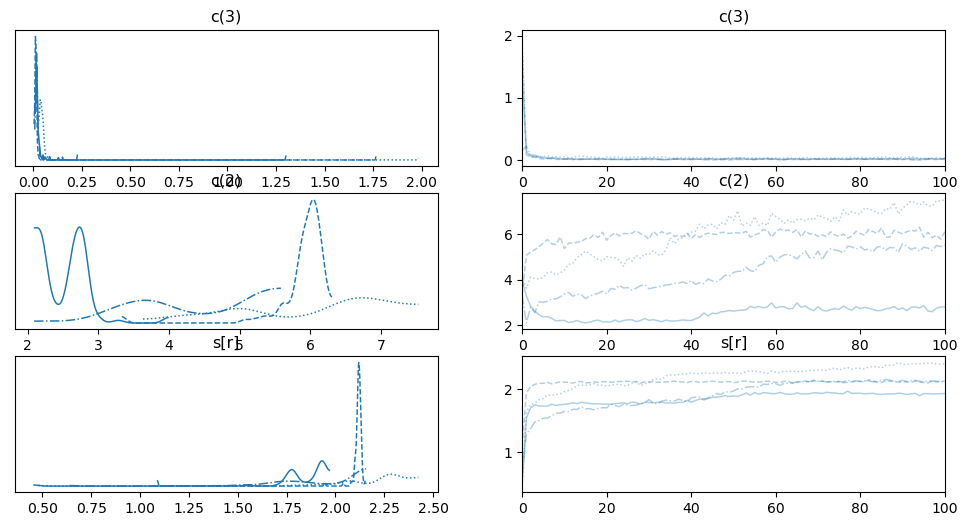

In [21]:
# az.plot_trace(idata, var_names=["c(3)", "c(2)", "c(1)", "s[r]"])
az.plot_trace(idata, var_names=["c(3)", "c(2)", "s[r]"])


<Figure size 640x480 with 0 Axes>

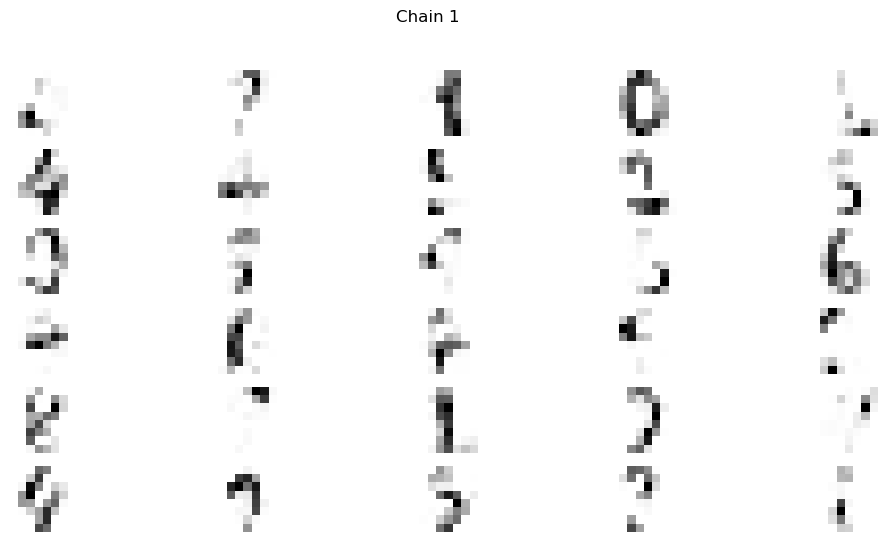

<Figure size 640x480 with 0 Axes>

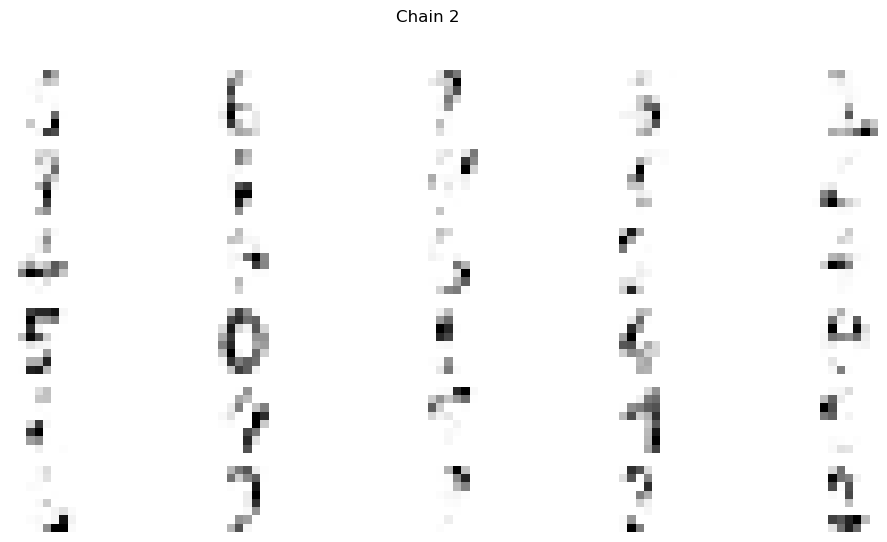

<Figure size 640x480 with 0 Axes>

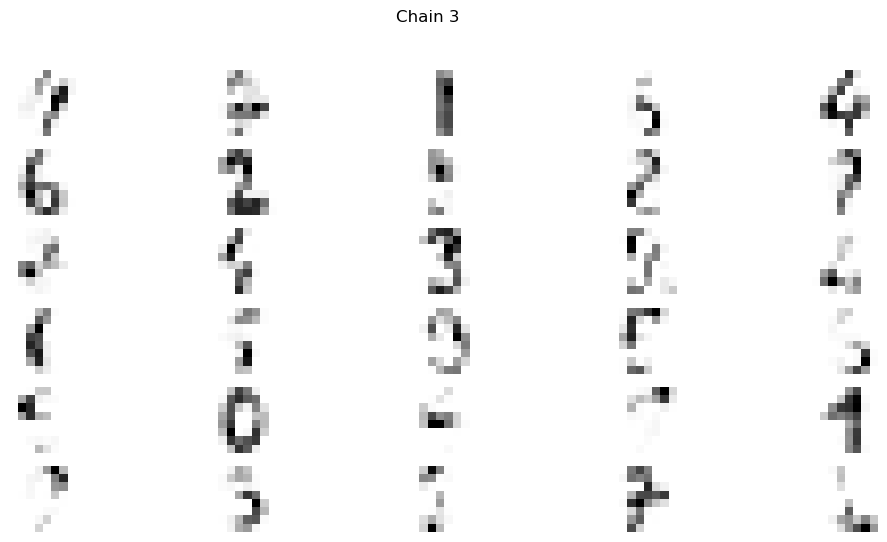

<Figure size 640x480 with 0 Axes>

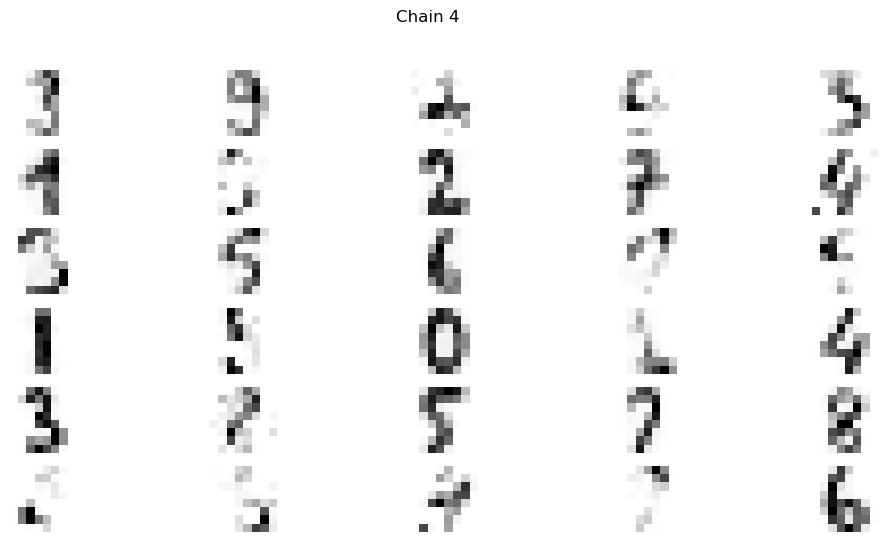

In [17]:
n_chains = 4
# Aggregate posterior samples to visualise.
phi_1st_layer = jnp.mean(states[f'{MODEL}/~/multinomial_layer']['phi'], axis=[1])

for i in range(n_chains):  # For each Markov chain.
    plt.figure()
    _, axes = plt.subplots(nrows=6, ncols=5, figsize=(12.5, 6))
    plt.suptitle(f'Chain {i+1}')
    # Plot the weights of all 10 hidden states.
    for ax, phi in zip(axes.flatten(), phi_1st_layer[i]):
        ax.set_axis_off()
        image = phi.reshape(8, 8)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")